In [1]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [7]:
# importing libreries and changing their name
import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [8]:
#Extracting data into dataframe
data=pd.read_csv('dow_jones.csv',header=1,parse_dates=True)
data.columns=['Month','DPS'] #DPS- Dollar Per Share
data

,Month,DPS
0,1915-01-01,56.55
1,1915-02-01,56.00
2,1915-03-01,58.30
3,1915-04-01,66.45
4,1915-05-01,65.95
...,...,...
643,1968-08-01,883.72
644,1968-09-01,922.80
645,1968-10-01,955.47
646,1968-11-01,964.12


In [9]:
data['Month']=pd.to_datetime(data['Month'])

In [10]:
#checking for null values
data.isnull().sum()

Month    0
DPS      0
dtype: int64

In [11]:
#checking for duplicate values
data[data.duplicated(keep=False)]

,Month,DPS


In [12]:
data.set_index('Month', inplace=True)
data.head()

,DPS
Month,
1915-01-01,56.55
1915-02-01,56.00
1915-03-01,58.30
1915-04-01,66.45
1915-05-01,65.95


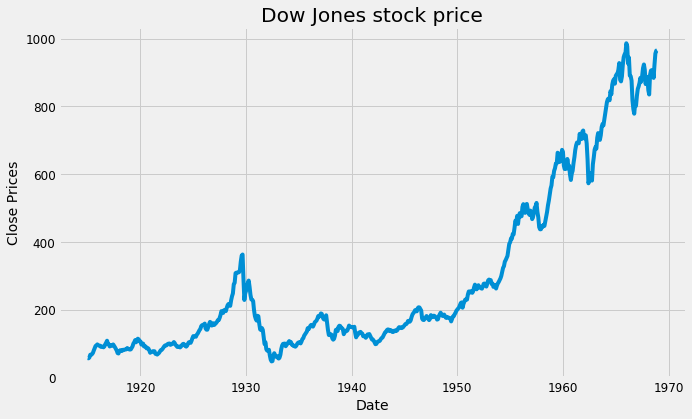

In [13]:
#plot stock price over years
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(data['DPS'])
plt.title('Dow Jones stock price')
plt.show()

<AxesSubplot:ylabel='Density'>

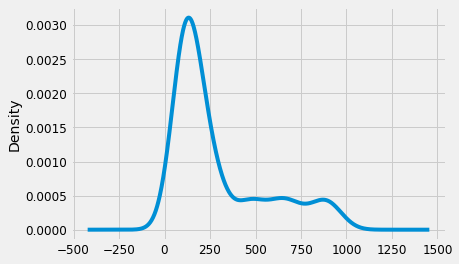

In [14]:
#Lets Visualize Distribution of the dataset
df_close = data['DPS']
df_close.plot(kind='kde')

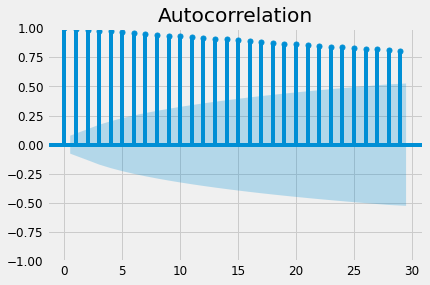

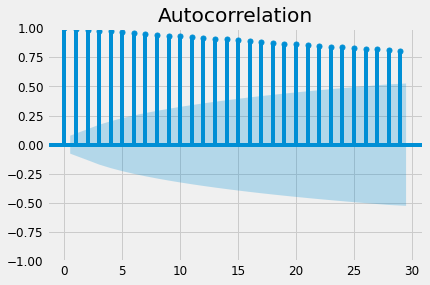

In [15]:
plot_acf(data)

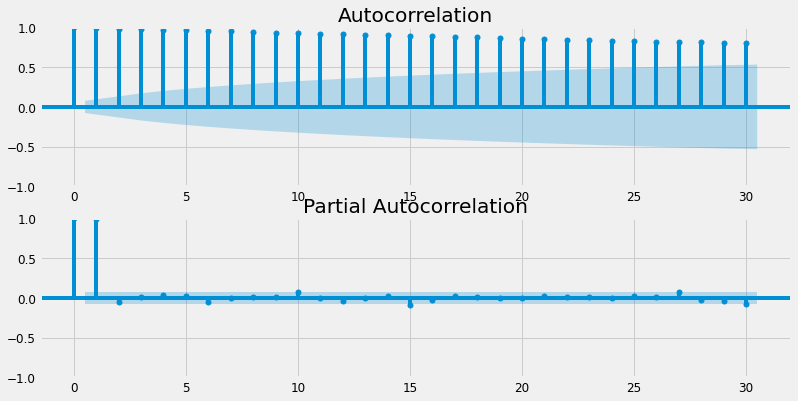

In [16]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(data.dropna(), ax=ax[0], lags=30)
ax[1] = plot_pacf(data.dropna(), ax=ax[1], lags=30)

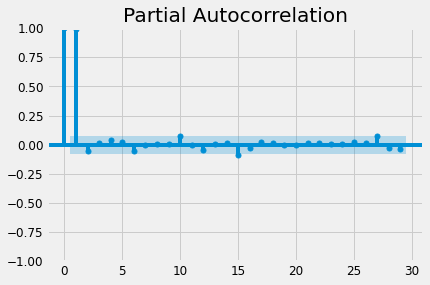

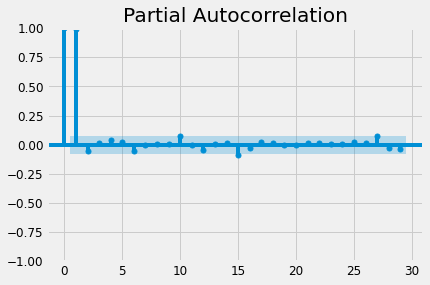

In [17]:
plot_pacf(data)

ADF (Augmented Dickey-Fuller) Test
One of the most widely used statistical tests is the Dickey-Fuller test. It can be used to determine whether or not a series has a unit root, and thus whether or not the series is stationary. This test’s null and alternate hypotheses are:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If the null hypothesis is not rejected, the series is said to be non-stationary. The series can be linear or difference stationary as a result of this.

The series becomes stationary if both the mean and standard deviation are flat lines (constant mean and constant variance)

In [18]:
from pmdarima.arima.stationarity import ADFTest

# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(data)
print(p_val)
print(should_diff)

0.9560299866328014
True


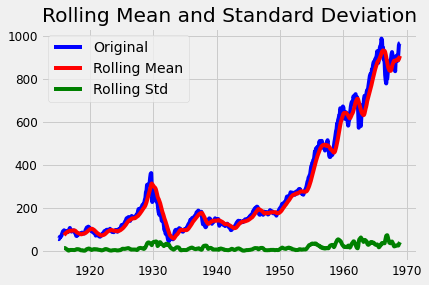

Results of dickey fuller test
Test Statistics                  1.405668
p-value                          0.997140
No. of lags used                10.000000
Number of observations used    637.000000
critical value (1%)             -3.440657
critical value (5%)             -2.866088
critical value (10%)            -2.569192
dtype: float64


In [19]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

The increasing mean and standard deviation may be seen in the graph above, indicating that our series isn’t stationary.

We can’t rule out the Null hypothesis because the p-value is bigger than 0.05. Additionally, the test statistics exceed the critical values. As a result, the data is nonlinear.

Seasonality and trend may need to be separated from our series before we can undertake a time series analysis. This approach will cause the resulting series to become stagnant.

Let’s isolate the time series from the Trend and Seasonality.

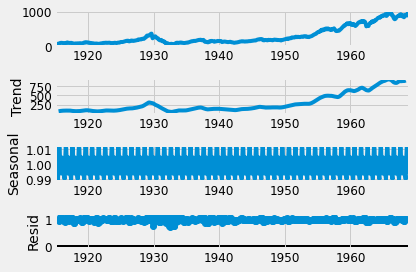

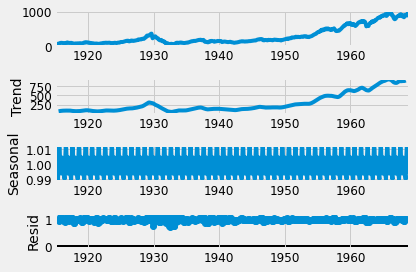

In [20]:
import statsmodels as sm
import statsmodels.api as sm
result = sm.tsa.seasonal_decompose(data, model = 'multiplicative')
#fig = 
result.plot()
#matplotlib.rcParams['figure.figsize'] = [30,5]

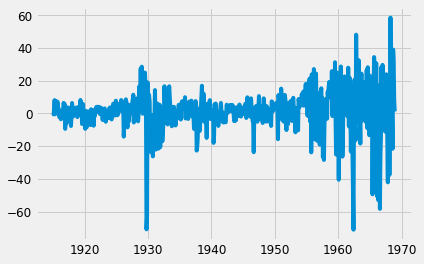

In [21]:
diff = data.diff()
diff.fillna(0,inplace=True)
plt.plot(diff)
plt.show()

In [22]:
from pmdarima.arima.stationarity import ADFTest

# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(diff)
print(p_val)
print(should_diff)

0.01
False


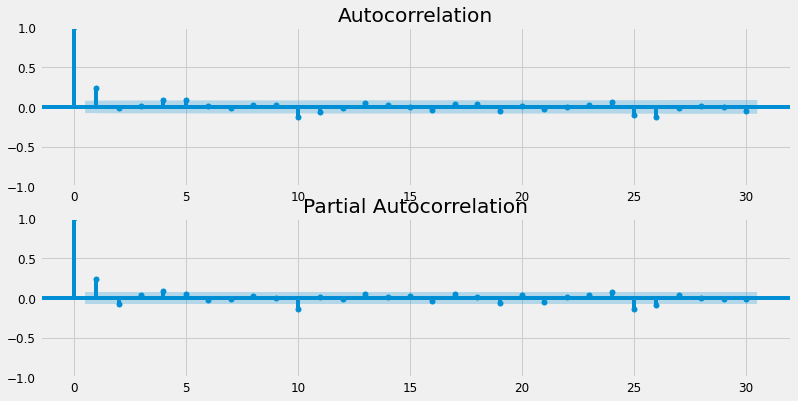

In [23]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(diff, ax=ax[0], lags=30)
ax[1] = plot_pacf(diff, ax=ax[1], lags=30)

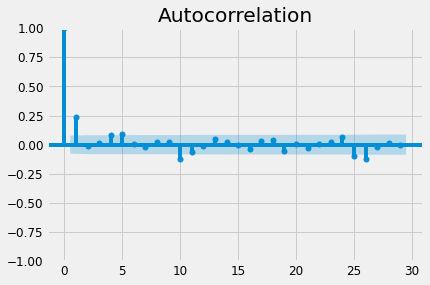

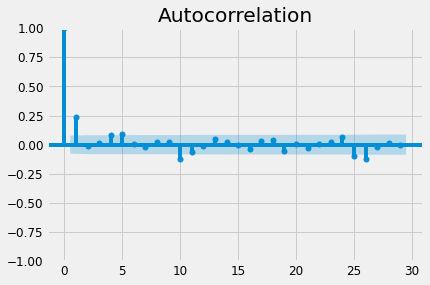

In [24]:
plot_acf(diff)

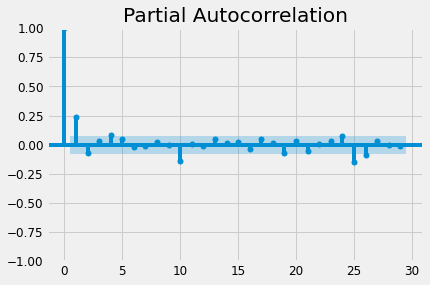

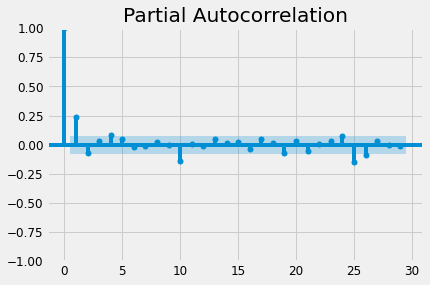

In [25]:
plot_pacf(diff)

No handles with labels found to put in legend.


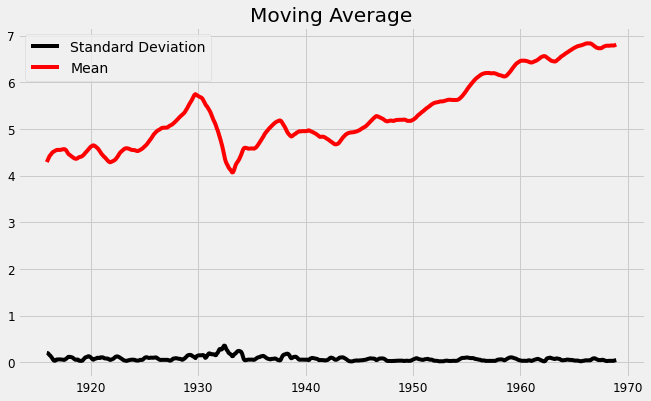

In [26]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [27]:

print('Possible ARIMA models given ACF and PACF')
print('ARIMA : [0,1,0]')
print('ARIMA : [1,1,0]')
print('ARIMA : [0,1,1]')
print('ARIMA : [1,1,1]')

Possible ARIMA models given ACF and PACF
ARIMA : [0,1,0]
ARIMA : [1,1,0]
ARIMA : [0,1,1]
ARIMA : [1,1,1]


Now we’ll develop an ARIMA model and train it using the stock’s closing price from the train data. So, let’s visualize the data by dividing it into training and test sets.

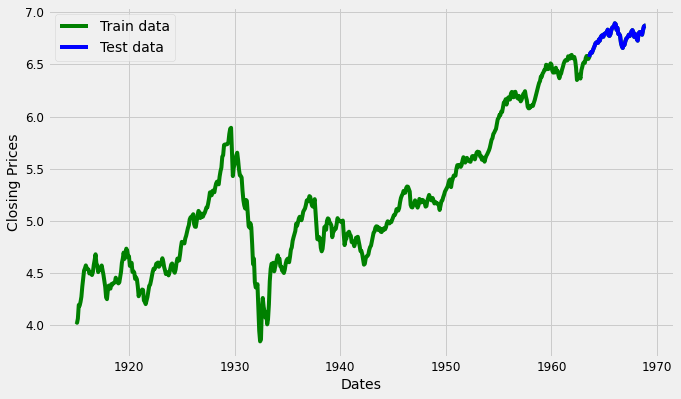

In [28]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1835.128, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1913.956, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1916.633, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1833.219, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1917.848, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1918.489, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1920.045, Time=0.34 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1919.120, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1918.060, Time=0.45 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1919.777, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 1.762 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  580
Model:               SARIMAX(2, 1, 0)   Log Likeliho

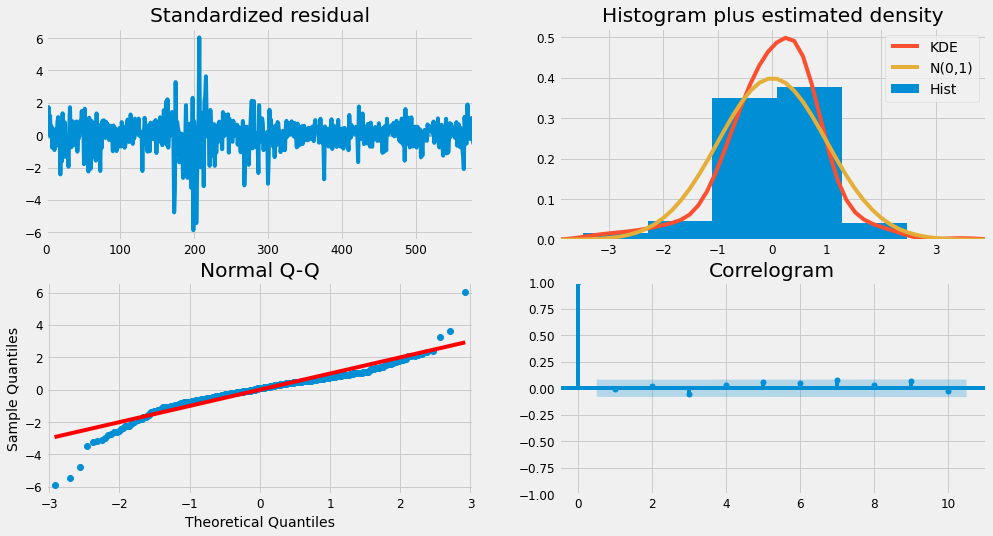

In [29]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Top left: The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

Top Right: The density plot on the top right suggests a normal distribution with a mean of zero.

Bottom left: The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.

Bottom Right: The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, you’ll need to add more Xs (predictors) to the model.

As a result, the Auto ARIMA model assigned the values 1, 1, and 2 to, p, d, and q, respectively.

In [30]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                    DPS   No. Observations:                  580
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 917.609
Date:                Mon, 16 May 2022   AIC                          -1833.219
Time:                        23:03:06   BIC                          -1828.857
Sample:                    04-01-1915   HQIC                         -1831.518
                         - 07-01-1963                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0025   7.12e-05     34.530      0.000       0.002       0.003
Ljung-Box (L1) (Q):                  75.90   Jarque-Bera (JB):              1116.73
Prob(Q):                              0.00   Pr

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
# Forecast
fitted.forecast(len(test_data), alpha=0.05)  # 95% conf

1963-08-01    6.552151
1963-09-01    6.552151
1963-10-01    6.552151
1963-11-01    6.552151
1963-12-01    6.552151
                ...   
1968-08-01    6.552151
1968-09-01    6.552151
1968-10-01    6.552151
1968-11-01    6.552151
1968-12-01    6.552151
Freq: MS, Name: predicted_mean, Length: 65, dtype: float64

In [32]:
fc=fitted.get_forecast(len(test_data), alpha=0.05).summary_frame()

In [33]:
fc

DPS,mean,mean_se,mean_ci_lower,mean_ci_upper
1963-08-01,6.552151,0.049596,6.454945,6.649358
1963-09-01,6.552151,0.070139,6.414681,6.689622
1963-10-01,6.552151,0.085903,6.383785,6.720518
1963-11-01,6.552151,0.099192,6.357738,6.746564
1963-12-01,6.552151,0.110900,6.334791,6.769511
...,...,...,...,...
1968-08-01,6.552151,0.387357,5.792945,7.311358
1968-09-01,6.552151,0.390519,5.786747,7.317555
1968-10-01,6.552151,0.393656,5.780599,7.323703
1968-11-01,6.552151,0.396768,5.774500,7.329803


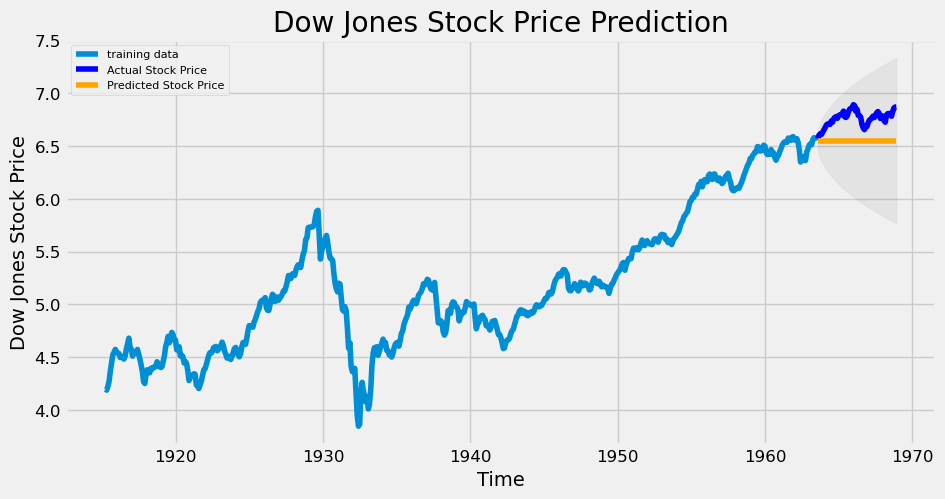

In [34]:
# Make as pandas series
fc_series = pd.Series(fc['mean'], index=test_data.index)
lower_series = pd.Series(fc['mean_ci_lower'], index=test_data.index)
upper_series = pd.Series(fc['mean_ci_upper'], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Dow Jones Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Dow Jones Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [35]:
# report performance
mse = mean_squared_error(test_data, fc['mean'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc['mean'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc['mean']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc['mean'] - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.05086938554691149
MAE: 0.2136721057622964
RMSE: 0.22554242515968362
MAPE: 0.03147002685436965


In [36]:
test_data.index

DatetimeIndex(['1963-08-01', '1963-09-01', '1963-10-01', '1963-11-01',
               '1963-12-01', '1964-01-01', '1964-02-01', '1964-03-01',
               '1964-04-01', '1964-05-01', '1964-06-01', '1964-07-01',
               '1964-08-01', '1964-09-01', '1964-10-01', '1964-11-01',
               '1964-12-01', '1965-01-01', '1965-02-01', '1965-03-01',
               '1965-04-01', '1965-05-01', '1965-06-01', '1965-07-01',
               '1965-08-01', '1965-09-01', '1965-10-01', '1965-11-01',
               '1965-12-01', '1966-01-01', '1966-02-01', '1966-03-01',
               '1966-04-01', '1966-05-01', '1966-06-01', '1966-07-01',
               '1966-08-01', '1966-09-01', '1966-10-01', '1966-11-01',
               '1966-12-01', '1967-01-01', '1967-02-01', '1967-03-01',
               '1967-04-01', '1967-05-01', '1967-06-01', '1967-07-01',
               '1967-08-01', '1967-09-01', '1967-10-01', '1967-11-01',
               '1967-12-01', '1968-01-01', '1968-02-01', '1968-03-01',
      